
# Objective
This notebook demonstrates how blending the capabilities of Elasticsearch as a vector database (VectorDB), search templates, and LLM functions can provide an intelligent query layer.

--This colab link needs to be updated prior to PR accepted!

<a target="_blank" href="https://colab.research.google.com/github/elastic/elasticsearch-labs/blob/main/supporting-blog-content/unifying-elastic-vector-database-and-llms-for-intelligent-query/Unifying_Elastic_Vector_Database_and_LLMs_for_Intelligent_Query.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


- **Elasticsearch as the VectorDB**: Acts as the core search engine, storing and retrieving dense vector embeddings efficiently.
- **Search Templates**: Marry index capabilities to query parameters, enabling dynamic query generation and structured search execution.
- **LLM Functions**: Parse the possible available parameters within a query and inject them into the search template for a more intelligent and context-aware retrieval process.

This combination enables a more sophisticated search experience, leveraging both structured and unstructured data retrieval methods.


## Deploy Elastic Cloud Serverless
An instance of Elastic serverless is required to run this notebook.  To launch an instance go to [cloud.elastic.co](https://cloud.elastic.co/)

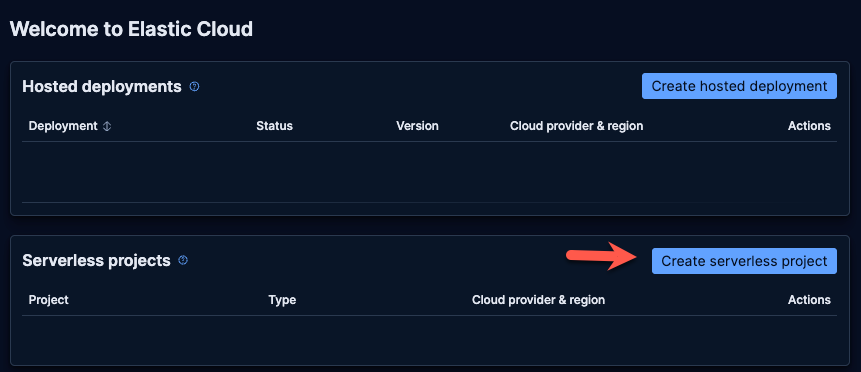

## Create API Key
Management-->Index Management-->API keys

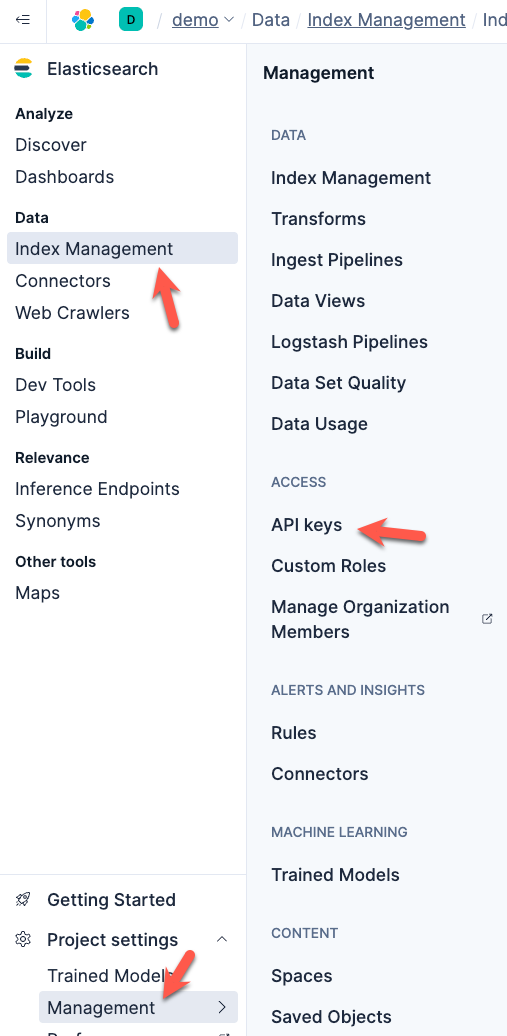

The api key Control security privileges.  The api key security privilages used for this demo:

```
{
  "read-only-role": {
    "cluster": [
      "manage"
    ],
    "indices": [
      {
        "names": [
          "*"
        ],
        "privileges": [
          "read"
        ],
        "allow_restricted_indices": false
      }
    ],
    "applications": [],
    "run_as": [],
    "metadata": {},
    "transient_metadata": {
      "enabled": true
    }
  }
}
```

Caution - This is not how you should design your api key security privilages in your cluster.  This is purely for this demo only.

## Install libraries

In [ ]:
!pip install "elasticsearch==8.17.0" openai streamlit -q

In [ ]:
import os
import json
from openai import AzureOpenAI
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from elasticsearch import Elasticsearch, helpers, NotFoundError
from elasticsearch.helpers import scan, bulk
import requests
from IPython.display import Markdown, display
import requests, json
from getpass import getpass
from google.colab import userdata
from elasticsearch.helpers import scan
import time

##Variables
Supply elasticsearch serverless cloud ID & API Key

Set Colab secrets

ELASTIC_SERVERLESS_CLOUD_ID

ELASTIC_SERVERLESS_API_KEY

GOOGLE_MAPS_API_KEY

GEOCODE_URL = 'https://maps.googleapis.com/maps/api/geocode/json'

AZURE_OPENAI_API_KEY

AZURE_OPENAI_DEPLOYMENT_NAME

AZURE_OPENAI_API_VERSION

AZURE_OPENAI_ENDPOINT


Details on each secret is defined in [part 1](https://github.com/elastic/elasticsearch-labs/blob/main/supporting-blog-content/unifying-elastic-vector-database-and-llms-for-intelligent-query/Unifying_Elastic_Vector_Database_and_LLMs_for_Intelligent_Query.ipynb)

In [ ]:
os.environ["ELASTIC_SERVERLESS_CLOUD_ID"] = userdata.get("ELASTIC_SERVERLESS_CLOUD_ID")
os.environ["ELASTIC_SERVERLESS_API_KEY"] = userdata.get("ELASTIC_SERVERLESS_API_KEY")
os.environ["GOOGLE_MAPS_API_KEY"] = userdata.get("GOOGLE_MAPS_API_KEY")
os.environ["GEOCODE_URL"] = "https://maps.googleapis.com/maps/api/geocode/json"
os.environ["AZURE_OPENAI_API_KEY"] = userdata.get("AZURE_OPENAI_API_KEY")
os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"] = userdata.get(
    "AZURE_OPENAI_DEPLOYMENT_NAME"
)
os.environ["AZURE_OPENAI_API_VERSION"] = userdata.get("AZURE_OPENAI_API_VERSION")
os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get("AZURE_OPENAI_ENDPOINT")

## Downloading properties data & search app code

In [ ]:
!mkdir /content/home-search-demo
!rm -f /content/home-search-demo/home-search-demo.py
# Target URL
url = "https://raw.githubusercontent.com/sunilemanjee/llm-functions/refs/heads/main/home-search-ai.py"

# Destination directory and file path
dest_dir = "/content/home-search-demo"
dest_file = os.path.join(dest_dir, "home-search-ai.py")

# Ensure the destination directory exists
os.makedirs(dest_dir, exist_ok=True)

# Download the file
response = requests.get(url)
response.raise_for_status()  # Raise an error for bad status

# Save the content to file
with open(dest_file, "wb") as f:
    f.write(response.content)

print(f"✅ File downloaded and saved to {dest_file}")

## Setting local variables

In [ ]:
# Elasticsearch Configurations
# Supply your elasticsearch serverless cloud id and api key
ELASTIC_SERVERLESS_CLOUD_ID = userdata.get("ELASTIC_SERVERLESS_CLOUD_ID")
ELASTIC_SERVERLESS_API_KEY = userdata.get("ELASTIC_SERVERLESS_API_KEY")


##Do not modify
RAW_INDEX_NAME = "properties_raw"
INDEX_NAME = "properties"
TEMPLATE_ID = "properties-search-template"
PROPERTIES_URL = (
    "https://sunmanapp.blob.core.windows.net/publicstuff/properties/properties.json"
)
ELSER_INFERENCE_ID = ".elser-2-elasticsearch"

## Connecting to Elastic Cloud Serverless

In [ ]:
es = Elasticsearch(
    cloud_id=ELASTIC_SERVERLESS_CLOUD_ID,
    api_key=ELASTIC_SERVERLESS_API_KEY,
    request_timeout=300,
)

es.info()

## Wake ELSER ML allocation
ML instances in serverless scale down to zero.  To avoid 408 error which is basically telling user to retry while ML instances wake up, here we simply wait

In [ ]:
response = es.inference.inference(
    inference_id=ELSER_INFERENCE_ID,
    task_type="sparse_embedding",
    input="hello world",
    timeout="120s",
)


print(response)

##Create Index
Creating a raw and property index

In [ ]:
def create_raw_index():
    mapping = {
        "mappings": {
            "dynamic": "false",
            "properties": {
                "additional_urls": {"type": "keyword"},
                "annual-tax": {"type": "integer"},
                "body_content": {"type": "text", "copy_to": ["body_content_phrase"]},
                "body_content_phrase": {"type": "text"},
                "domains": {"type": "keyword"},
                "full_html": {"type": "text", "index": False},
                "geo_point": {
                    "properties": {"lat": {"type": "float"}, "lon": {"type": "float"}}
                },
                "location": {"type": "geo_point"},
                "headings": {"type": "text"},
                "home-price": {"type": "integer"},
                "id": {"type": "keyword"},
                "last_crawled_at": {"type": "date"},
                "latitude": {"type": "float"},
                "links": {"type": "keyword"},
                "listing-agent-info": {"type": "text"},
                "longitude": {"type": "float"},
                "maintenance-fee": {"type": "integer"},
                "meta_description": {"type": "text"},
                "meta_keywords": {"type": "keyword"},
                "number-of-bathrooms": {"type": "float"},
                "number-of-bedrooms": {"type": "float"},
                "property-description": {"type": "text"},
                "property-features": {"type": "text"},
                "property-status": {"type": "keyword"},
                "square-footage": {"type": "float"},
                "title": {"type": "text"},
                "url": {"type": "keyword"},
                "url_host": {"type": "keyword"},
                "url_path": {"type": "keyword"},
                "url_path_dir1": {"type": "keyword"},
                "url_path_dir2": {"type": "keyword"},
                "url_path_dir3": {"type": "keyword"},
                "url_port": {"type": "keyword"},
                "url_scheme": {"type": "keyword"},
            },
        }
    }

    if es.indices.exists(index=RAW_INDEX_NAME):
        es.indices.delete(index=RAW_INDEX_NAME)
        print(f"🗑️ Index '{RAW_INDEX_NAME}' deleted.")

    es.indices.create(index=RAW_INDEX_NAME, body=mapping)
    print(f"✅ Index '{RAW_INDEX_NAME}' created.")


create_raw_index()

In [ ]:
def create_properties_index():
    mapping = {
        "mappings": {
            "dynamic": "false",
            "properties": {
                "additional_urls": {"type": "keyword"},
                "annual-tax": {"type": "integer"},
                "body_content": {"type": "text", "copy_to": ["body_content_semantic"]},
                "body_content_semantic": {
                    "type": "semantic_text",
                    "inference_id": ELSER_INFERENCE_ID,
                    "model_settings": {"task_type": "sparse_embedding"},
                },
                "body_content_phrase": {"type": "text"},
                "domains": {"type": "keyword"},
                "full_html": {"type": "text", "index": False},
                "geo_point": {
                    "properties": {"lat": {"type": "float"}, "lon": {"type": "float"}}
                },
                "location": {"type": "geo_point"},
                "headings": {"type": "text"},
                "home-price": {"type": "integer"},
                "id": {"type": "keyword"},
                "last_crawled_at": {"type": "date"},
                "latitude": {"type": "float"},
                "links": {"type": "keyword"},
                "listing-agent-info": {"type": "text"},
                "longitude": {"type": "float"},
                "maintenance-fee": {"type": "integer"},
                "meta_description": {"type": "text"},
                "meta_keywords": {"type": "keyword"},
                "number-of-bathrooms": {"type": "float"},
                "number-of-bedrooms": {"type": "float"},
                "property-description": {"type": "text"},
                "property-features": {"type": "text"},
                "property-status": {"type": "keyword"},
                "square-footage": {"type": "float"},
                "title": {"type": "text"},
                "url": {"type": "keyword"},
                "url_host": {"type": "keyword"},
                "url_path": {"type": "keyword"},
                "url_path_dir1": {"type": "keyword"},
                "url_path_dir2": {"type": "keyword"},
                "url_path_dir3": {"type": "keyword"},
                "url_port": {"type": "keyword"},
                "url_scheme": {"type": "keyword"},
            },
        }
    }

    if es.indices.exists(index=INDEX_NAME):
        es.indices.delete(index=INDEX_NAME)
        print(f"🗑️ Index '{INDEX_NAME}' deleted.")

    es.indices.create(index=INDEX_NAME, body=mapping)
    print(f"✅ Index '{INDEX_NAME}' created.")


create_properties_index()

##Search Template
Removes the existing properties-search-template if present and replaces it with an updated version. This ensures the template is always current and correctly structured for search operations.

In [ ]:
search_template_content = {
    "script": {
        "lang": "mustache",
        "source": """{
            "_source": false,
            "size": 5,
            "fields": ["title", "annual-tax", "maintenance-fee", "number-of-bathrooms", "number-of-bedrooms", "square-footage", "home-price", "property-features"],
            "retriever": {
                "standard": {
                    "query": {
                        "semantic": {
                            "field": "body_content_semantic",
                            "query": "{{query}}"
                        }
                    },
                    "filter": {
                        "bool": {
                            "must": [
                                {{#distance}}{
                                    "geo_distance": {
                                        "distance": "{{distance}}",
                                        "location": {
                                            "lat": {{latitude}},
                                            "lon": {{longitude}}
                                        }
                                    }
                                }{{/distance}}
                                {{#bedrooms}}{{#distance}},{{/distance}}{
                                    "range": {
                                        "number-of-bedrooms": {
                                            "gte": {{bedrooms}}
                                        }
                                    }
                                }{{/bedrooms}}
                                {{#bathrooms}}{{#distance}}{{^bedrooms}},{{/bedrooms}}{{/distance}}{{#bedrooms}},{{/bedrooms}}{
                                    "range": {
                                        "number-of-bathrooms": {
                                            "gte": {{bathrooms}}
                                        }
                                    }
                                }{{/bathrooms}}
                                {{#tax}}{{#distance}}{{^bedrooms}}{{^bathrooms}},{{/bathrooms}}{{/bedrooms}}{{/distance}}{{#bedrooms}}{{^bathrooms}},{{/bathrooms}}{{/bedrooms}}{{#bathrooms}},{{/bathrooms}}{
                                    "range": {
                                        "annual-tax": {
                                            "lte": {{tax}}
                                        }
                                    }
                                }{{/tax}}
                                {{#maintenance}}{{#distance}}{{^bedrooms}}{{^bathrooms}}{{^tax}},{{/tax}}{{/bathrooms}}{{/bedrooms}}{{/distance}}{{#bedrooms}}{{^bathrooms}}{{^tax}},{{/tax}}{{/bathrooms}}{{/bedrooms}}{{#bathrooms}}{{^tax}},{{/tax}}{{/bathrooms}}{{#tax}},{{/tax}}{
                                    "range": {
                                        "maintenance-fee": {
                                            "lte": {{maintenance}}
                                        }
                                    }
                                }{{/maintenance}}
                                {{#square_footage}}{{#distance}}{{^bedrooms}}{{^bathrooms}}{{^tax}}{{^maintenance}},{{/maintenance}}{{/tax}}{{/bathrooms}}{{/bedrooms}}{{/distance}}{{#bedrooms}}{{^bathrooms}}{{^tax}}{{^maintenance}},{{/maintenance}}{{/tax}}{{/bathrooms}}{{/bedrooms}}{{#bathrooms}}{{^tax}}{{^maintenance}},{{/maintenance}}{{/tax}}{{/bathrooms}}{{#tax}}{{^maintenance}},{{/maintenance}}{{/tax}}{{#maintenance}},{{/maintenance}}{
                                    "range": {
                                        "square-footage": {
                                            "gte": {{square_footage}}
                                        }
                                    }
                                }{{/square_footage}}
                                {{#home_price}}{{#distance}}{{^bedrooms}}{{^bathrooms}}{{^tax}}{{^maintenance}}{{^square_footage}},{{/square_footage}}{{/maintenance}}{{/tax}}{{/bathrooms}}{{/bedrooms}}{{/distance}}{{#bedrooms}}{{^bathrooms}}{{^tax}}{{^maintenance}}{{^square_footage}},{{/square_footage}}{{/maintenance}}{{/tax}}{{/bathrooms}}{{/bedrooms}}{{#bathrooms}}{{^tax}}{{^maintenance}}{{^square_footage}},{{/square_footage}}{{/maintenance}}{{/tax}}{{/bathrooms}}{{#tax}}{{^maintenance}}{{^square_footage}},{{/square_footage}}{{/maintenance}}{{/tax}}{{#maintenance}}{{^square_footage}},{{/square_footage}}{{/maintenance}}{{#square_footage}},{{/square_footage}}{
                                    "range": {
                                        "home-price": {
                                            "lte": {{home_price}}
                                        }
                                    }
                                }{{/home_price}}
                            ] {{#feature}} ,
                            "should": [
                                    {
                                    "wildcard": {
                                        "property-features": {
                                            "value": "{{feature}}",
                                            "case_insensitive": true
                                        }
                                    }
                                }
                            ],
                            "minimum_should_match": 1
                            {{/feature}}
                        }
                    }
                }
            }
        }""",
    }
}


def delete_search_template(template_id):
    """Deletes the search template if it exists"""
    try:
        es.delete_script(id=template_id)
        print(f"Deleted existing search template: {template_id}")
    except Exception as e:
        if "not_found" in str(e):
            print(f"Search template '{template_id}' not found, skipping delete.")
        else:
            print(f"Error deleting template '{template_id}': {e}")


def create_search_template(
    template_id=TEMPLATE_ID, template_content=search_template_content
):
    """Creates a new search template"""
    try:
        es.put_script(id=template_id, body=template_content)
        print(f"Created search template: {template_id}")
    except Exception as e:
        print(f"Error creating template '{template_id}': {e}")


create_search_template()

## Ingest property data

In [ ]:
def download_and_parallel_bulk_load():
    response = requests.get(PROPERTIES_URL, stream=True)
    response.raise_for_status()

    def generate_actions():
        for line in response.iter_lines():
            if line:
                doc = json.loads(line.decode("utf-8"))
                yield {"_index": RAW_INDEX_NAME, "_source": doc}

    success_count = 0
    for ok, result in helpers.parallel_bulk(
        es,
        actions=generate_actions(),
        thread_count=4,
        chunk_size=200,
        request_timeout=60,
    ):
        if ok:
            success_count += 1

    print(
        f"✅ Successfully indexed {success_count} documents into '{RAW_INDEX_NAME}' using parallel_bulk"
    )


download_and_parallel_bulk_load()

## Reindex property data into target index which will also host elserized field

In [ ]:
def async_reindex_with_tracking():
    # Step 1: Start reindexing asynchronously
    response = es.reindex(
        body={"source": {"index": RAW_INDEX_NAME}, "dest": {"index": INDEX_NAME}},
        wait_for_completion=False,  # Run async
    )

    task_id = response["task"]
    print(f"🚀 Reindex started. Task ID: {task_id}")

    # Step 2: Poll for completion
    while True:
        task_status = es.tasks.get(task_id=task_id)
        completed = task_status.get("completed", False)

        if completed:
            stats = task_status["response"]
            print(
                f"✅ Reindex complete! {stats['created']} docs reindexed, took {stats['took']}ms"
            )
            break
        else:
            print("⏳ Reindex in progress... checking again in 10 seconds.")
            time.sleep(10)


async_reindex_with_tracking()

## Clean up

In [ ]:
if es.indices.exists(index=RAW_INDEX_NAME):
    es.indices.delete(index=RAW_INDEX_NAME)
    print(f"🗑️ Index '{RAW_INDEX_NAME}' deleted.")

## Host IP
This is required to run streamlit app in colab. The output will be a IP address.  Use that IP address in the next step

In [ ]:
!wget -q -O - ipv4.icanhazip.com

## Streamlit UI
Run cell and wait for your url is: ....
That is the URL for the property search app. You will be asked to provide a secret. Use the IP address from the cell output above.  You will be then redirected to the property search UI

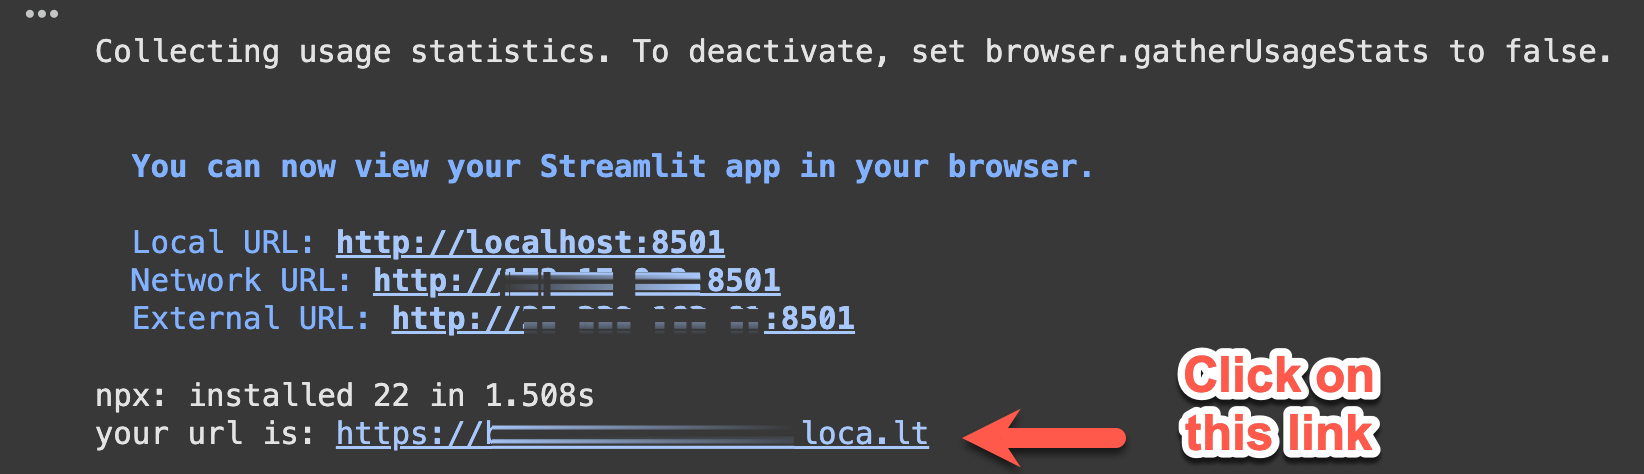

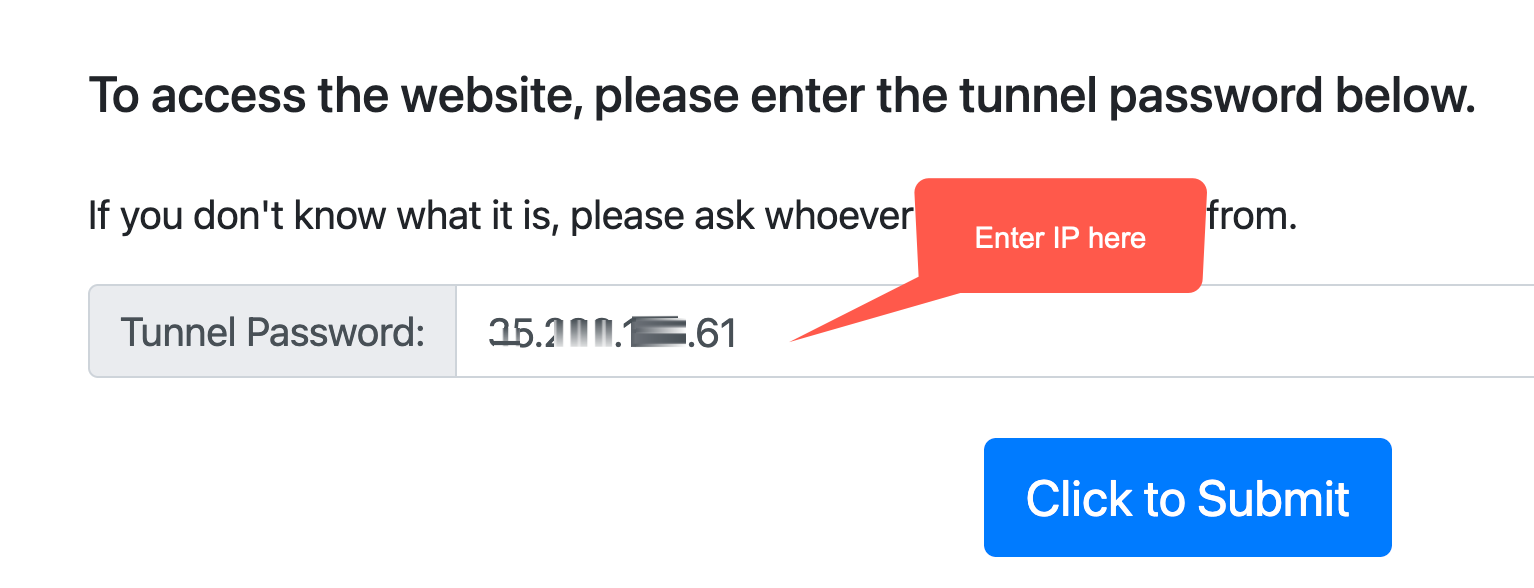

In [ ]:
! streamlit run /content/home-search-demo/home-search-ai.py & npx localtunnel --port 8501

## Start searching for a home...

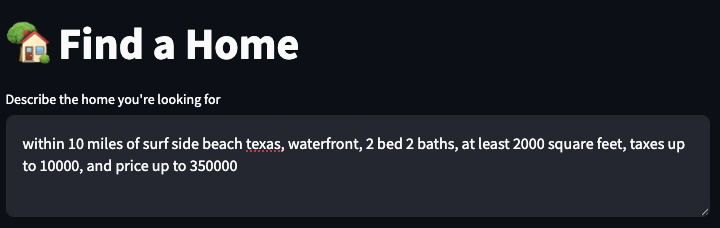